# Introduction

In this assignment you will be given a series of tasks about using the library `power-grid-model`. The agenda includes:

* Load input (From Power flow assignment)
* Numpy tips and PGM related recommendations
* Types of Dataset
* Miscellaneous PGM features
* Selective output
* Complex Simulations
    * Multiple Timeseries
    * Side topic: PGM DS library
    * Contingency Analysis
        * Topology caching
        * Simulation design exercise
    * Dynamic operating Envelope
        * Simulation design exercise
    * Additional content
        * Simulation design exercise

# Preparation

First import everything we need for this workshop:

In [1]:
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from power_grid_model import (
    PowerGridModel,
    CalculationType,
    CalculationMethod,
    ComponentType,
    DatasetType,
    initialize_array,
    attribute_dtype,
    attribute_empty_value,
    power_grid_meta_data
)

from power_grid_model.validation import assert_valid_input_data, assert_valid_batch_data

from power_grid_model_ds import Grid, PowerGridModelInterface
from power_grid_model_ds.enums import NodeType
from power_grid_model_ds.visualizer import visualize

from utils import Timer
import psutil
import os
from collections import Counter

In [2]:
np.set_printoptions(precision=3, linewidth=100)

# Topology Data and Timeseries load profiles 

(Reused from Power flow assignment)

In [3]:
def load_input_data() -> dict[str, np.ndarray]:
    input_data = {}
    for component in [
        ComponentType.node,
        ComponentType.line,
        ComponentType.source,
        ComponentType.sym_load,
    ]:
        # Use pandas to read CSV data
        df = pd.read_csv(f"../data/{component.value}.csv")

        # Initialize array
        input_data[component] = initialize_array(DatasetType.input, component, len(df))

        # Fill the attributes
        for attr, values in df.items():
            input_data[component][attr] = values

        # Print some debug info
        print(f"{component:9s}: {len(input_data[component]):4d}")

    return input_data


input_data = load_input_data()


ComponentType.node: 2001
ComponentType.line: 2000
ComponentType.source:    1
ComponentType.sym_load: 2000


In [4]:
model = PowerGridModel(input_data=input_data)

Lets use these number timestamps for all calculations in the notebook.

In [5]:
n_timestamps = 24 * 7

In [6]:
# Generate random load profile oh hourly data
dti = pd.date_range("2022-01-01", periods=n_timestamps, freq="h")
n_loads = len(input_data[ComponentType.sym_load])
load_id = input_data[ComponentType.sym_load]["id"]
load_p = input_data[ComponentType.sym_load]["p_specified"]
profile = np.tile(load_p, (n_timestamps, 1)) + 1e5 * np.random.randn(
    n_timestamps, n_loads
)

In [7]:
# Initialize an empty load profile
load_profile_row_based = initialize_array(
    DatasetType.update, ComponentType.sym_load, profile.shape
)

load_profile_row_based["id"] = load_id
load_profile_row_based["p_specified"] = profile
load_profile_row_based["q_specified"] = 0.0

# Construct the update data
update_data_row_based = {ComponentType.sym_load: load_profile_row_based}


# Side topics related to numpy


## Calcualting Memory usage

In [8]:
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Current memory usage: {mem_info.rss / 1024 / 1024:.2f} MB")


def print_memory_used_by_object(object):
    print(f"Memory used by object: {object.__sizeof__() / 1024 / 1024} MB")


def print_memory_used_by_dict(dictionary):
    print(
        f"Memory used by dictionary: {sum(object.__sizeof__() / 1024 / 1024 for object in dictionary.values())} MB"
    )


def print_memory_used_by_array(array: np.ndarray):
    print(f"Memory used by numpy array: {array.nbytes / 1024 / 1024} MB")


print_memory_usage()

print_memory_used_by_object([1] * 1000)
print_memory_used_by_object(
    {"a": [1] * 1000}
)  # This is because dictionary stores only references

print_memory_used_by_dict({"a": [1] * 1000})

print_memory_used_by_array(np.random.rand(1000, 1000))

Current memory usage: 170.34 MB
Memory used by object: 0.00766754150390625 MB
Memory used by object: 0.00016021728515625 MB
Memory used by dictionary: 0.00766754150390625 MB
Memory used by numpy array: 7.62939453125 MB


## Correct dtype for PGM


Use of initialize_array is recommended for most uses. 
However if you wish to translate the dtype into the one PGM uses, you can use  `initialize_array(dataset_type, component_type, empty_shape, empty=True)` or `dtype = power_grid_meta_data[dataset_type][component_type].dtype` to find the dtype of the row based data. You can use this to change to the appropriate type which is required by PGM.

For dtype of individual attribute which would be required in columnar data creation, you can use `attribute_dtype(data_type, component_type, attribute)`. The missing value can be filled by `attribute_empty_value(data_type, component_type, attribute)` 

Also check for contigious-ness. 

Check if a type-cast to this dtype creates a copy. Maybe such a copy is redundant.

In [9]:
initialize_array(DatasetType.input, ComponentType.sym_load, 0, empty=True)
# power_grid_meta_data[DatasetType.input][ComponentType.sym_load].dtype

array([],
      dtype={'names': ['id', 'node', 'status', 'type', 'p_specified', 'q_specified'], 'formats': ['<i4', '<i4', 'i1', 'i1', '<f8', '<f8'], 'offsets': [0, 4, 8, 9, 16, 24], 'itemsize': 32, 'aligned': True})

In [10]:
attribute_dtype(DatasetType.input, ComponentType.transformer, "sn")

dtype('float64')

All available attributes are visible via

In [11]:
initialize_array(DatasetType.input, ComponentType.sym_load, 0, empty=True).dtype.names

('id', 'node', 'status', 'type', 'p_specified', 'q_specified')

## Views vs copies

Check numpy documentation for when certain functions or features create a view or copy. 

* Views simplify assignment of values
* Uneccesary copies here are the first you can aim to eliminate to improve overall performance.


https://numpy.org/doc/stable/user/basics.copies.html


Checking if view or copy

if `array.base is None` -> copy; else -> view


In [12]:
import numpy as np
x = np.arange(9)

y = x.reshape(3, 3)

assert y.base is not None  # .reshape() creates a view

z = y[[2, 1]]

assert z.base is None  # advanced indexing creates a copy

## Garbage collection for views/copies

### Higher than required memory usage

In [13]:
def calculate_and_give_first_50_loading(model, update_data):
    output_data = model.calculate_power_flow(
        update_data=update_data,
        calculation_method=CalculationMethod.newton_raphson
    )
    return output_data[ComponentType.line]["loading"][:50]


first_50_loading = calculate_and_give_first_50_loading(model, update_data_row_based)


print(f"Shape of returned array: {first_50_loading.shape}")
print_memory_used_by_array(first_50_loading)

print(f"Actual shape of memory: {first_50_loading.base.shape}")
print_memory_used_by_array(first_50_loading.base)

Shape of returned array: (50, 2000)
Memory used by numpy array: 0.762939453125 MB
Actual shape of memory: (168, 2000)
Memory used by numpy array: 25.634765625 MB


### Right Way to return values

Use .copy() to convert a view into a copy.

In [14]:
def calculate_and_give_first_50_loading(model, update_data):
    output_data = model.calculate_power_flow(
        update_data=update_data,
        calculation_method=CalculationMethod.newton_raphson,
        threading=0
    )
    return output_data[ComponentType.line]["loading"][:50].copy()


first_50_loading = calculate_and_give_first_50_loading(model, update_data_row_based)
print(f"Shape of returned array: {first_50_loading.shape}")
print_memory_used_by_array(first_50_loading)
assert first_50_loading.base is None

Shape of returned array: (50, 2000)
Memory used by numpy array: 0.762939453125 MB


### Contigious Data

The input and update dataset needs to be a contigious dataset.
A transposed dataset for example would be copied first whereas a sliced dataset would not be.
A reshaped dataset mostly would be contigious.
Check arr.flags for contigiousness


In [15]:
loads = np.zeros((1000, 10),dtype=np.float64)
print(loads.flags)
print(loads.reshape(10, 20, 50).flags)
print(loads.T.flags)

print(np.ascontiguousarray(loads) is loads)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

  C_CONTIGUOUS : False
  F_CONTIGUOUS : True
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

True


## Accessing and assigning to PGM arrays

In [16]:
loads = initialize_array(DatasetType.update, ComponentType.sym_load, (1000, 10))
loads[:] = (99, 1, 100.0, 100.0)

def copy_or_view(arr: np.ndarray) -> str:
    return "copy" if arr.base is None else "view"

In [17]:


print("Single batch all components: `loads[:, 0]` gets a :", copy_or_view(loads[:, 0]))
print("All batch single components: `loads[0, :]` gets a :", copy_or_view(loads[0, :]))
print("Sliced batch all components: `loads[:5, :]` gets a :", copy_or_view(loads[:5, :]))
print("Multiple batch via advanced indexing all components: `loads[[1,2,3], :]` gets a :", copy_or_view(loads[[1,2,3], :]))  # Advanced indexing creates a copy
print("All batch Multiple components via advanced indexing: `loads[:, [1,2,3]]` gets a :", copy_or_view(loads[:, [1,2,3]]))  # Deceptive: view of another copy

Single batch all components: `loads[:, 0]` gets a : view
All batch single components: `loads[0, :]` gets a : view
Sliced batch all components: `loads[:5, :]` gets a : view
Multiple batch via advanced indexing all components: `loads[[1,2,3], :]` gets a : copy
All batch Multiple components via advanced indexing: `loads[:, [1,2,3]]` gets a : view


### Attribute access

Attribute access has similar behavior

In [18]:
print("Single batch all components: `loads['p_specified']` gets a :", copy_or_view(loads["p_specified"]))
print("Single batch all components: `loads['p_specified'][:,0]` gets a :", copy_or_view(loads["p_specified"][:, 0]))
print("Single batch all components: `loads['p_specified'][0, :]` gets a :", copy_or_view(loads["p_specified"][0, :]))
print("Sliced batch all components: `loads['p_specified'][:5, :]` gets a :", copy_or_view(loads["p_specified"][:5, :]))
print("Single batch all components: `loads['p_specified'][[1, 2, 3], :]` gets a :", copy_or_view(loads["p_specified"][[1, 2, 3], :]))
print("Single batch all components: `loads['p_specified'][:, [1, 2, 3]]` gets a :", copy_or_view(loads["p_specified"][:, [1, 2, 3]])) 

Single batch all components: `loads['p_specified']` gets a : view
Single batch all components: `loads['p_specified'][:,0]` gets a : view
Single batch all components: `loads['p_specified'][0, :]` gets a : view
Sliced batch all components: `loads['p_specified'][:5, :]` gets a : view
Single batch all components: `loads['p_specified'][[1, 2, 3], :]` gets a : copy
Single batch all components: `loads['p_specified'][:, [1, 2, 3]]` gets a : view


Multi field indexing

In [19]:
print("Multiple attributes: `loads[['p_specified', 'q_specified']][:, [1, 2, 3]]` gets a :", copy_or_view(loads[["p_specified", "q_specified"]]))

Multiple attributes: `loads[['p_specified', 'q_specified']][:, [1, 2, 3]]` gets a : view


A common source of confusion is when dealing with numpy arrays view and copy variables. They look the same. 
* Modifications on view modifies the view as well as the original array.
* Modifications on copy modifies only that copy.


In [20]:
loads = initialize_array(DatasetType.update, ComponentType.sym_load, (1000, 4))
loads[:] = (99, 1, 100.0, 100.0)

x = loads["p_specified"][:3, :]
loads["p_specified"][:3, :] = 123456
print(x)


[[123456. 123456. 123456. 123456.]
 [123456. 123456. 123456. 123456.]
 [123456. 123456. 123456. 123456.]]


In [21]:
loads = initialize_array(DatasetType.update, ComponentType.sym_load, (1000, 4))
loads[:] = (99, 1, 100.0, 100.0)

x = loads["p_specified"][[1, 2, 3], :]
loads["p_specified"][[1, 2, 3], :] = 123456
print(x)


[[100. 100. 100. 100.]
 [100. 100. 100. 100.]
 [100. 100. 100. 100.]]


#### Deceiptive: It was a view of a copy

In [22]:
loads = initialize_array(DatasetType.update, ComponentType.sym_load, (1000, 4))
loads[:] = (99, 1, 100.0, 100.0)

x = loads["p_specified"][:, [1, 2, 3]]
loads["p_specified"][:, [1, 2, 3]] = 123456
print(x)


[[100. 100. 100.]
 [100. 100. 100.]
 [100. 100. 100.]
 ...
 [100. 100. 100.]
 [100. 100. 100.]
 [100. 100. 100.]]


### Assignment via tuples

In [23]:
loads = initialize_array(DatasetType.input, ComponentType.asym_load, (10, 5))
loads["p_specified"] = 1000
loads["p_specified"] = [[1000], [1000], [1000], [1000], [1000]]
# ('id', 'node', 'status', 'type', 'p_specified', 'q_specified')
loads[:, 0] = (1, 2, 1, 0, 123, 0)
loads[:] = (1, 2, 1, 0, 123, 0)
loads[:2]


array([[(1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.])],
       [(1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.]),
        (1, 2, 1, 0, [123., 123., 123.], [0., 0., 0.])]],
      dtype={'names': ['id', 'node', 'status', 'type', 'p_specified', 'q_specified'], 'formats': ['<i4', '<i4', 'i1', 'i1', ('<f8', (3,)), ('<f8', (3,))], 'offsets': [0, 4, 8, 9, 16, 40], 'itemsize': 64, 'aligned': True})

# Types of datasets 

### Row based format

In [24]:
print_memory_used_by_array(update_data_row_based[ComponentType.sym_load])

Memory used by numpy array: 7.6904296875 MB


In [25]:
# Run Newton Raphson power flow (this may take a minute...)
with Timer("Batch Calculation using Newton-Raphson row based data"):
    output_data = model.calculate_power_flow(
        update_data=update_data_row_based,
        calculation_method=CalculationMethod.newton_raphson,
        threading=0,
    )

print_memory_used_by_dict(output_data)

Execution time for Batch Calculation using Newton-Raphson row based data is 0.211790 s
Memory used by dictionary: 56.412353515625 MB


### Columnar data format

In [26]:
# Construct the update data
update_data_columnar = {ComponentType.sym_load: {"p_specified": profile}}

print_memory_used_by_array(profile)  # in MB

Memory used by numpy array: 2.5634765625 MB


Skipping ids is possible under certain conditions

In [27]:
with Timer("Batch Calculation using Newton-Raphson columnar data"):
    output_data = model.calculate_power_flow(
        update_data=update_data_columnar,
        calculation_method=CalculationMethod.newton_raphson,
        threading=0
    )

Execution time for Batch Calculation using Newton-Raphson columnar data is 0.256051 s


### Selective Output

It is possible to output only selected attributes via output_component_types. The effect on memory usage is huge.

In [28]:
with Timer("Batch Calculation using Newton-Raphson columnar data"):
    output_data_selective = model.calculate_power_flow(
        update_data=update_data_columnar,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types={ComponentType.line: ["loading"]},
        threading=0
    )

print(
    f"output_data_selective contains following: \n"
    f"Keys: {output_data_selective.keys()}. \n"
    f"Attributes: {output_data_selective[ComponentType.line].keys()}"
)
print_memory_used_by_array(output_data_selective[ComponentType.line]["loading"])

Execution time for Batch Calculation using Newton-Raphson columnar data is 0.253432 s
output_data_selective contains following: 
Keys: dict_keys([<ComponentType.line: 'line'>]). 
Attributes: dict_keys(['loading'])
Memory used by numpy array: 2.5634765625 MB


Lets define all limit related attributes to use in upcoming simulation

In [29]:
limit_related_output = {
    ComponentType.line: ["loading"],
    ComponentType.node: ["u_pu"],
    ComponentType.transformer: ["loading"],
}

#### Clear memory

In [30]:
del load_profile_row_based, output_data, output_data_selective

# Miscellanious PGM features

## Sparse datasets

For unequal update sets use linear data + pointers. 
This way of providing update would likely be a niche.

Columnar sparse dataset representation for example can be as follows:

In [31]:
update_data_sparse = {
    ComponentType.line: {
        "indptr": [0, 1, 1, 2],
        "data": {
            "p_specified": [1000, 2000]
        }
    }
}

## Validating large batch data

Since the validator for large batch dataset is expensive, we can choose to validate only some part of data.
The result of the validator is also difficult to interpret with many errors on a large dataset.
Maximum data errors typically occur in the input dataset.
Hence we can slice the update data to only certain batches and validate it.

In [32]:
with Timer("Validation of full batch data"):
    assert_valid_batch_data(
        input_data=input_data,
        update_data=update_data_row_based,
        calculation_type=CalculationType.power_flow,
    )

with Timer("Validation of partial batch data"):
    assert_valid_batch_data(
        input_data=input_data,
        update_data={k: v[:5, :] for k, v in update_data_row_based.items()},
        calculation_type=CalculationType.power_flow,
    )

Execution time for Validation of full batch data is 0.892844 s
Execution time for Validation of partial batch data is 0.031841 s


# Complex simulations

Often times we wish to run multiple simulations at once. 
These power flow calculations have multiple dimensions associated with them where the information regarding that particular simulation is put in.
The way to simulate these via PGM most effectively is to flatten all the excess dimension into one, ie. of batches. 
This makes the entire simulation including and most likely excluding PGM most efficient, readable and less bug-prone.


## Multiple Timeseries

We are now going to simulate multiple timeseries in a single power flow calculation and later the results would be aggregated from the output numpy arrays.


Here we have a EV growth related scenario in a neighbourhood.
For this simulation we have yearly EV consumption profiles available for 10 different customers.
We shall subset these profiles and timestamps to align with the data in this notebook  

In [33]:
# Hourly EV profile data for one year. Row = hours, column = profiles
ev_profile = (
    pd.read_csv("../data/ev_profile.csv").to_numpy(
        dtype=np.float64, copy=False, na_value=np.nan
    )
    * 1000
)  # kw
# Select first n_timestamps and first n profiles
n_ev_profiles = 10
assert n_timestamps <= ev_profile.shape[0]
assert n_ev_profiles <= ev_profile.shape[1]
ev_profile = ev_profile[:n_timestamps, :n_ev_profiles]



Since the EV growth at each node is uncertain, we can sample different EV growth scenarios.
Lets consider: 
* The maximal EV sales in a region is a known quantity (denoted by n_vehicles).
* The spread of EVs across each loaded nodes is equal (denoted by pvals of n_vehicle_each_node).
* We conduct n_experiments samples for monte carlo simulation
* Each EV profile is assigned to each EV equally random (denoted by pvals of distributions).

In [34]:
n_vehicles = 100000
n_experiments = 11

rng = np.random.default_rng(12345)

n_vehicle_each_node = rng.multinomial(
    n=n_vehicles, pvals=[1 / n_loads] * n_loads, size=n_experiments
)
print(f"Shape of n_vehicle_each_node: {n_vehicle_each_node.shape}")

distributions = rng.multinomial(
    n=n_vehicle_each_node, pvals=[1 / n_ev_profiles] * n_ev_profiles
)
print(f"Shape of distributions: {distributions.shape}")

ev_timeseries = np.transpose(distributions @ ev_profile.T, axes=(0, 2, 1))
print(f"Shape of ev_timeseries: {ev_timeseries.shape}")

ev_timeseries_q = ev_timeseries * np.tan(np.arccos(0.95))

combined_timeseries = profile[np.newaxis, :, :] + ev_timeseries
print(f"Shape of combined_timeseries: {combined_timeseries.shape}")


Shape of n_vehicle_each_node: (11, 2000)
Shape of distributions: (11, 2000, 10)
Shape of ev_timeseries: (11, 168, 2000)
Shape of combined_timeseries: (11, 168, 2000)


Create columnar update data and run calculation

In [35]:
update_data_multi_timeseries = {
    ComponentType.sym_load: {
        "p_specified": combined_timeseries.reshape(-1, n_loads),
        "q_specified":  ev_timeseries.reshape(-1, n_loads),
    }
}

In [36]:
with Timer("Run multitimeseries PF"):
    output_data = model.calculate_power_flow(
        update_data=update_data_multi_timeseries,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types=limit_related_output,
        threading=0
    )

reshaped_loading_data = output_data[ComponentType.line]["loading"].reshape(n_experiments, n_timestamps, n_loads)
print(f"Shape of reshaped_loading_data: {reshaped_loading_data.shape}")


Execution time for Run multitimeseries PF is 1.509123 s
Shape of reshaped_loading_data: (11, 168, 2000)


Aggregate result on the basis of experiments of monte carlo simulation

In [37]:
np.mean(reshaped_loading_data, axis=0)

array([[1.689, 1.512, 1.334, ..., 0.519, 0.351, 0.181],
       [1.676, 1.498, 1.331, ..., 0.545, 0.367, 0.184],
       [1.702, 1.521, 1.346, ..., 0.5  , 0.338, 0.179],
       ...,
       [1.753, 1.577, 1.396, ..., 0.552, 0.359, 0.182],
       [1.723, 1.554, 1.369, ..., 0.552, 0.368, 0.185],
       [1.714, 1.536, 1.358, ..., 0.533, 0.354, 0.188]], shape=(168, 2000))

In [38]:
del output_data, reshaped_loading_data

When PF is run in loop


In [39]:
load_id_loop = np.tile(input_data[ComponentType.sym_load]["id"], (n_timestamps, 1))
output_datas = []
with Timer("Run multi-timeseries PF in loop"):
    for experiment in range(n_experiments):
        update_data_loop = {
            ComponentType.sym_load: {
                "id": load_id_loop,
                "p_specified": combined_timeseries[experiment, :, :],
                "q_specified": ev_timeseries_q[experiment, :, :],
            }
        }
        output_data = model.calculate_power_flow(
            update_data=update_data_loop,
            calculation_method=CalculationMethod.newton_raphson,
            output_component_types=limit_related_output,
            threading=0,
        )
        output_datas.append(output_datas)

del output_datas

Execution time for Run multi-timeseries PF in loop is 3.535915 s



The difference between this method and one big batch is indeed not very large, but this is a significant for performance improvement. 

The combining/seprating numpy arrays is a lot more wasteful.

The calculating of mean on `output_datas` list is more difficult than a numpy array.

## PGM DS library

Converting to and from a PGM DS grid can be done via `PowerGridModelInterface`.

In [40]:
core_interface = PowerGridModelInterface(input_data=input_data)
grid = core_interface.create_grid_from_input_data()

### Visualization of grid

In [41]:
visualize(grid)

### Graph operations

Some graphical operations possible via PGM-DS. Custom ones can be implemented in your simulation via rustworkx.

In [42]:

grid.node.node_type[0] = NodeType.SUBSTATION_NODE

# Downstream nodes from node 1 with the substation node as reference
print(f"1. {grid.get_downstream_nodes(1)}")

# In case of multiple substations, find nearest one
print(f"2. {grid.get_nearest_substation_node(10)}")

# Find all paths between node 1 and node 10
print(f"3. {grid.graphs.active_graph.get_all_paths(1, 10)}")

# Find shortest path between node 1 and node 10
print(f"4. {grid.graphs.active_graph.get_shortest_path(1, 10)}")

# All components in this graph
print(f"5. {len(grid.graphs.active_graph.get_components())}")

# All components connected to node 1
print(f"6. {len(grid.graphs.active_graph.get_connected(node_id=1))}")

# All components connected to node 0, ignoring nodes 1 and 2
print(f"7. {len(grid.graphs.active_graph.get_connected(node_id=0, nodes_to_ignore=[1, 2]))}")


1. [2, 3, 4, 5, 6, 7, 8, 9, 10]
2.  id | u_rated | node_type | feeder_branch_id | feeder_node_id 
 0  | 10500.0 |     1     |   -2147483648    |  -2147483648   
3. [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
4. ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 9)
5. 1
6. 2000
7. 1990


### Array operations

Many array operations are possible. Such operations are possible via numpy too but are not as intuitive.

In [43]:
grid.line.filter(from_node=[0, 1, 2, 3, 4], to_node=[0, 1, 2, 3, 4, 5, 6, 7], mode_="AND")

LineArray([[(2001, 0, 1, 1, 1, -2147483648, -2147483648, False, 0.101, 0.104, 3.249e-05, 0.099, 500.)
 (2002, 1, 2, 1, 1, -2147483648, -2147483648, False, 0.098, 0.103, 3.143e-05, 0.109, 500.)
 (2003, 2, 3, 1, 1, -2147483648, -2147483648, False, 0.109, 0.098, 3.369e-05, 0.095, 500.)]]... + 2 more rows)

## Contingency Analysis with timeseries

Here we perform a selective contingency analysis on specific branches for all timesteps.

Use graph operations to find top 5 ranked branches which most nodes depend on.

In [44]:
# TODO fix from/to
# Lines with most most number of dependent nodes
contingency_count = 5

all_branches = []
for node in grid.node.id:
    paths = grid.graphs.active_graph.get_all_paths(node, grid.source.node[0])
    for path in paths:
        all_branches += [(path[idx + 1], path[idx]) for idx in range(len(path) - 1)]

print(f"Branch list {all_branches}")

counts = Counter(all_branches)
top_branches_from_to_counts = counts.most_common(contingency_count)
from_nodes = [i[0][0] for i in top_branches_from_to_counts]
to_nodes = [i[0][1] for i in top_branches_from_to_counts]

top_branches_id = grid.line.filter(from_node=from_nodes, to_node=to_nodes, mode_="AND").id

print(f"top 5 branches {top_branches_id}")

Branch list [(0, 1), (1, 2), (0, 1), (2, 3), (1, 2), (0, 1), (3, 4), (2, 3), (1, 2), (0, 1), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (5, 6), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (6, 7), (5, 6), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (7, 8), (6, 7), (5, 6), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (8, 9), (7, 8), (6, 7), (5, 6), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (9, 10), (8, 9), (7, 8), (6, 7), (5, 6), (4, 5), (3, 4), (2, 3), (1, 2), (0, 1), (0, 11), (11, 12), (0, 11), (12, 13), (11, 12), (0, 11), (13, 14), (12, 13), (11, 12), (0, 11), (14, 15), (13, 14), (12, 13), (11, 12), (0, 11), (15, 16), (14, 15), (13, 14), (12, 13), (11, 12), (0, 11), (16, 17), (15, 16), (14, 15), (13, 14), (12, 13), (11, 12), (0, 11), (17, 18), (16, 17), (15, 16), (14, 15), (13, 14), (12, 13), (11, 12), (0, 11), (18, 19), (17, 18), (16, 17), (15, 16), (14, 15), (13, 14), (12, 13), (11, 12), (0, 11), (19, 20), (18, 19), (17, 18), (16, 17), (15, 16), (14, 15), (13, 14), (12, 13), (11, 12), (0, 11), (0, 21

Design batches for simulation in PGM

In [45]:
combos_contingencies = np.eye(contingency_count, dtype=np.uint8)

combos_contingencies_timestamps = np.tile(combos_contingencies, (1, n_timestamps))

line_update = initialize_array(
    DatasetType.update,
    ComponentType.line,
    (contingency_count * n_timestamps, contingency_count),
)
line_update["id"] = top_branches_id
line_update["from_status"] = 1 - combos_contingencies_timestamps.reshape(-1, contingency_count)
line_update["to_status"] = 1 - combos_contingencies_timestamps.reshape(-1, contingency_count)

Run contingency analysis on timeseries by using Timeseries data from earlier cell

In [46]:
load_profile_combined = initialize_array(
    DatasetType.update,
    ComponentType.sym_load,
    (contingency_count * profile.shape[0], profile.shape[1]),
)

load_profile_combined["p_specified"] = np.tile(
    profile, (contingency_count, 1)
)

load_profile_combined["q_specified"] = 0.0

update_data_combined = {
    ComponentType.line: line_update,
    ComponentType.sym_load: load_profile_combined,
}

with Timer("Batch Calculation with contingencies and load profiles"):
    output_data_combined = model.calculate_power_flow(
        update_data=update_data_combined,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types=limit_related_output,
        threading=0
    )

Execution time for Batch Calculation with contingencies and load profiles is 3.640553 s


Plot loading on first line for all situations

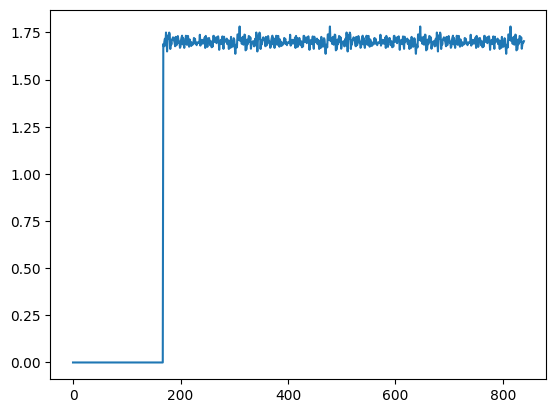

In [47]:
plt.plot(output_data_combined[ComponentType.line]["loading"][:, 0])

In [48]:
del output_data_combined

#### Question regarding topology caching

Instead of designing the simulation like we did in this way:

```
1 0 0 0 timestep 1
1 0 0 0 timestep 2
1 0 0 0 timestep 3
...

0 1 0 0 timestep 1
0 1 0 0 timestep 2
0 1 0 0 timestep 3
...

```

What if contingencies are designed this way?


```
0 1 1 1   timestep 1
1 0 1 1
1 1 0 1
1 1 1 0

0 1 1 1   timestep 2
1 0 1 1
1 1 0 1
1 1 1 0
```


### Simulation design exercise

* Can you give an example on how you can set up a network reconfiguration study based on the example above?
* What graph related operations are needed?
    * Is it possible to do those via PGM-DS?
* What result attributes are to be checked? Do they need to be aggregated?

## Dynamic operating envelope

Calculate the operating envelope for all timesteps at node 10 based on voltage limits.


Find the sym load connected to node 10

In [49]:
sym_load_node_10 = grid.sym_load.filter(node=10).id
sym_load_node_10_idx = model.get_indexer(ids=sym_load_node_10, component_type=ComponentType.sym_load)[0]

* Create a grid of P and Q values between a max and minimum range.
* Create multiple timeseries for each point in the grid
* Add the values in the grid to the load at node 10. Rest timeseries would remain the same.

In [50]:
min_p = -1e7
max_p = 1e7
min_q = -1e7
max_q = 1e7
resolution = 11

p_linear_values = np.linspace(start=min_p, stop=max_p, num=resolution)
q_linear_values = np.linspace(start=min_q, stop=max_q, num=resolution)

p_values, q_values = np.meshgrid(p_linear_values, q_linear_values, copy=False)
print(f"p_values shape: {p_values.shape} and q_values shape: {q_values.shape}")

p_envelope = np.tile(profile, (resolution, resolution, 1, 1))
print(f"p_envelope shape: {p_envelope.shape}")
p_envelope[:, :, :, sym_load_node_10_idx] += p_values[:, :, np.newaxis]

q_envelope = np.zeros(p_envelope.shape)
q_envelope[:, :, :, sym_load_node_10_idx] += q_values[:, :, np.newaxis]


p_values shape: (11, 11) and q_values shape: (11, 11)
p_envelope shape: (11, 11, 168, 2000)


Create update data and run simulation

In [51]:
update_data_envelope = {
    ComponentType.sym_load: {
        "p_specified": p_envelope.reshape(-1, n_loads),
        "q_specified": q_envelope.reshape(-1, n_loads),
    }
}

In [52]:
with Timer("Batch Calculation with grid of P and Q to calculate an envelope of operation"):
    output_data_envelope = model.calculate_power_flow(
        update_data=update_data_envelope,
        calculation_method=CalculationMethod.newton_raphson,
        output_component_types=limit_related_output,
        threading=0
    )

nodal_voltages = output_data_envelope[ComponentType.node]["u_pu"].reshape(resolution, resolution, n_timestamps, -1)
print(f"nodal_voltages shape: {nodal_voltages.shape}")

Execution time for Batch Calculation with grid of P and Q to calculate an envelope of operation is 38.109268 s
nodal_voltages shape: (11, 11, 168, 2001)


Next Step to calculate the envelope:

* Calculate the index mask where the voltage does not cross above or below the voltage limit for each timestep
* Apply this mask on the grid of P and Q for each time step.

In [53]:
u_low_lim = 0.95
u_high_lim = 1.03

max_voltage_scenario = np.max(nodal_voltages, axis=3) > u_high_lim
min_voltage_scenario = np.min(nodal_voltages, axis=3) < u_low_lim
points_outside_limits =  np.logical_or(max_voltage_scenario, min_voltage_scenario)


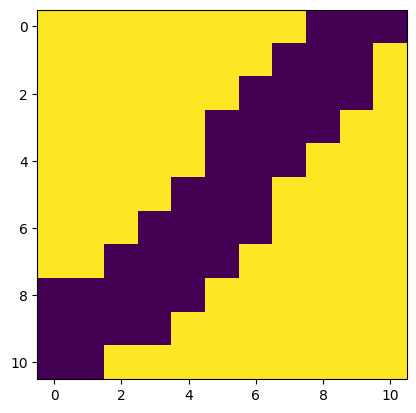

In [54]:
plt.imshow(points_outside_limits[:,:, 0])

### Simulation Design Exercise

* Can you give anadditional examples of calculating flexibility envelopes? Maybe with more details? (based on technical limits and not economic ones) 
* What result attributes are to be checked? Do they need to be aggregated?

# Additional Content

#### Additional simulation design exercise

* Can you give an example of how we can implement a control related action via PGM? 
* Draw a block diagram of the control?
    * Is this scheme efficient?
    * How do we create batches for such simulation. 
* What result attributes are to be checked? Do they need to be aggregated?